In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
import joblib
np.random.seed(0)
sns.set_style("darkgrid")

orig = pd.read_parquet("/Users/lselig/selig-fa/finance/.data/evs_ratios.parquet")
print(orig.shape)
for c in orig:
    print(c)
features = pd.read_parquet("/Users/lselig/selig-fa/finance/.data/evs_ratios_preprocessed.parquet")
features = features.drop(columns = ["marketCapitalization"])
meta_cols = ["stockPrice", "date", "year",
             "symbol", "quarter", "cik", "isEtf", "isActivelyTrading", "isFund", "country"]


holdout = features[features.year == 2022]
features = features[features.year != 2022]

holdout_meta = holdout[meta_cols]
features_meta = features[meta_cols]

labels_holdout = np.log10(holdout.stockPrice.values)
labels = np.log10(features.stockPrice.values)

holdout = holdout.drop(columns = meta_cols)
features = features.drop(columns = meta_cols)




(182752, 82)
symbol
date
stockPrice
numberOfShares
marketCapitalization
minusCashAndCashEquivalents
addTotalDebt
enterpriseValue
quarter
currentRatio
quickRatio
cashRatio
daysOfSalesOutstanding
daysOfInventoryOutstanding
operatingCycle
daysOfPayablesOutstanding
cashConversionCycle
grossProfitMargin
operatingProfitMargin
pretaxProfitMargin
netProfitMargin
effectiveTaxRate
returnOnAssets
returnOnEquity
returnOnCapitalEmployed
netIncomePerEBT
ebtPerEbit
ebitPerRevenue
debtRatio
debtEquityRatio
longTermDebtToCapitalization
totalDebtToCapitalization
interestCoverage
cashFlowToDebtRatio
companyEquityMultiplier
receivablesTurnover
payablesTurnover
inventoryTurnover
fixedAssetTurnover
assetTurnover
operatingCashFlowPerShare
freeCashFlowPerShare
cashPerShare
payoutRatio
operatingCashFlowSalesRatio
freeCashFlowOperatingCashFlowRatio
cashFlowCoverageRatios
shortTermCoverageRatios
capitalExpenditureCoverageRatio
dividendPaidAndCapexCoverageRatio
dividendPayoutRatio
priceBookValueRatio
priceToBookR

In [108]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.99)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_train = y_train.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train)

X_train = scaler_X.transform(X_train)
y_train = scaler_y.transform(y_train)
X_test = scaler_X.transform(X_test)

(75324, 205) (761, 205) (75324,) (761,)


In [109]:
model = Ridge()
cv = 10
alphas_ = [10 ** i for i in range(-5, 5)]
print(alphas_)
param_grid = {"alpha": alphas_}
search = GridSearchCV(model, param_grid, scoring = "r2", n_jobs = -1, cv=cv, verbose = 3)
result = search.fit(X_train, y_train)
alpha_opt = search.best_params_["alpha"]

print(f"{alpha_opt = }")
print(f"{result.cv_results_['mean_test_score']}")

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END ......................alpha=1e-05;, score=0.922 total time=   1.0s
[CV 6/10] END ......................alpha=1e-05;, score=0.915 total time=   1.0s
[CV 10/10] END .....................alpha=1e-05;, score=0.924 total time=   1.0s
[CV 9/10] END ......................alpha=1e-05;, score=0.935 total time=   1.0s
[CV 4/10] END ......................alpha=1e-05;, score=0.924 total time=   1.0s
[CV 3/10] END ......................alpha=1e-05;, score=0.931 total time=   1.0s
[CV 2/10] END ......................alpha=1e-05;, score=0.935 total time=   1.0s
[CV 7/10] END ......................alpha=1e-05;, score=0.928 total time=   1.0s
[CV 5/10] END ......................alpha=1e-05;, score=0.929 total time=   1.0s
[CV 8/10] END ......................alpha=1e-05;, score=0.916 total time=   1.0s
[CV 1/10] END .....................alpha=0.0001;, score=0.922 total 

In [111]:

model = RandomForestRegressor()
cv = 10
param_grid = {"criterion": ["squared_error", "absolute_error"],
              "max_depth": [5, 6, 7, 8, 9, 10],
              "n_estimators": [100, 200, 500]
              }
reg = RandomizedSearchCV(model, param_grid, scoring = "r2", n_jobs = -1, cv = cv, verbose = 10)
search = reg.fit(X_train, y_train.ravel())
print(search.best_params_)
joblib.dump(search, "/Users/lselig/selig-fa/finance/.data/random_forest.pkl")
# search = joblib.load("/Users/lselig/selig-fa/finance/.data/ridge.pkl")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 6/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 7/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 8/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 2/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 3/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 1/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 5/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 4/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 9/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100...
[CV 10/10; 1/10] START criterion=squared_error, max_depth=10, n_estimators=100..
[CV 1/10; 2/10] START criterion=squared_error, max_depth=8, n_estimators=200....
[CV 2/10; 2/10] START criterion=squared_error,

KeyboardInterrupt: 

0.9556835717670548
[[-1.37278069e+00  5.41296295e-02  4.31529393e-02  1.56468458e+00
   1.47806352e-02 -6.85050004e-02 -4.90896306e-02 -1.24212452e-01
  -1.11228030e-02  1.05268955e-02  1.57299995e-02  1.36170351e-02
   8.93717427e-03 -5.10792576e-03  9.02545336e-04 -1.28747384e-02
   6.61763259e-03  1.22065393e-02  1.05268955e-02  1.14909119e-02
  -4.53025010e-01 -9.64107024e-02 -1.47818174e-02  3.38599507e-01
  -1.29254135e-01 -5.10461097e-04  1.68633888e-02  1.33993471e-01
   7.52650790e-02 -3.23683320e-02  1.56607328e-01  2.41168203e-02
  -2.17263219e-02  4.55187891e-02  3.55749405e-02  3.48754980e-02
   3.48754980e-02  1.36274735e-01  1.47546405e-02 -1.25399987e-02
   3.03100700e-02  3.03100700e-02 -9.83322663e-04  1.36274735e-01
  -2.72327634e-03  3.48754980e-02  3.57254130e-02  1.09618697e-02
  -9.45396414e-04 -3.06054411e-02 -6.83558363e-03  1.69150897e-03
   1.09631928e-02 -1.98313080e-02 -1.03730051e-03 -8.77639598e-03
   8.77639598e-03  6.50610519e-03 -2.99870655e-03 -1.9540

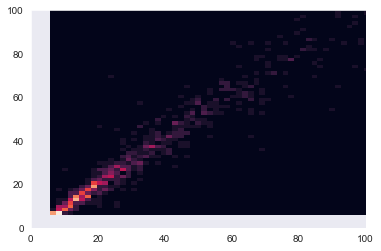

In [110]:
model = Ridge(alpha = 1)
model = model.fit(X_train, y_train)
# joblib.dump(model, "/Users/lselig/selig-fa/finance/.data/ridge.pkl")
# model = joblib.load("/Users/lselig/selig-fa/finance/.data/ridge.pkl")
pred = model.predict(X_test)
pred = scaler_y.inverse_transform(pred).ravel()
true = y_test

pred = 10 ** pred
true = 10 ** true
print(model.score(X_test, scaler_y.transform(y_test.reshape(-1, 1))))
print(model.coef_)
print(pred)
print(true)
print(np.corrcoef(pred, true)[0, 1])


plt.hist2d(pred, true, bins = 450)
plt.xlim(0, 100)
plt.ylim(0, 100)
# plt.scatter(pred, true)
plt.show()


In [ ]:
pred = model.predict(scaler_X.transform(holdout))
pred = scaler_y.inverse_transform(pred).ravel()
pred = 10 ** pred

In [ ]:
from collections import namedtuple
from operator import attrgetter
Valuation = namedtuple("Valuation", 'true, pred, multi, symbol, period, date')
vs = []

diff = pred - 10 ** labels_holdout
plt.plot(diff)
plt.title("Higher y = Buy me")
plt.ylabel("Pred - True")
plt.show()
for i, d in enumerate(diff):
    relevance = pred[i] / (10 ** labels_holdout[i])
    if(relevance > 1.75):
        v = Valuation(10 ** labels_holdout[i],
                      pred[i],
                      relevance,
                      holdout_meta.iloc[i].symbol,
                      holdout_meta.iloc[i].quarter,
                      holdout_meta.iloc[i].date)
        vs.append(v)
        # print(f"{d = }, {relevance = }, {pred[i] = }, {10 ** labels_holdout[i] = }\n, {holdout_meta.iloc[i].to_string()}\n\n")
vs.sort(key = attrgetter("multi"), reverse = True)
for v in vs:
    print(v)
print(vs)